# Instruções Gerais

- O código deve estar separado em funções - cada uma com o propósito claro e específico;

- As funções devem ter um cabeçalho explicando (brevemente) o que elas recebem, o que elas retornam e o que elas fazem;

- O código deve estar *printando* saídas intermediárias com suas respectivas explicações/interpretações técnicas - não precisa ser nada muito extenso!

- O código deve estar, no mínimo, rodando sem depender de nenhum arquivo externo (ou se depender, o mesmo deve ser enviado junto com o código em um *.zip*).

- As saídas intermediárias também devem conter os gráficos explicativos do modelo simulado.

# Projeto GBM/Monte Carlo

In [1]:
# Importando as bibliotecas necessárias
import numpy as np
import pandas as pd
import scipy.stats as sts
import matplotlib.pyplot as plt
import yahoo_fin.stock_info as si
import warnings

warnings.filterwarnings('ignore')

## Etapa 1:

Implementar a dinâmica do Movimento *Browniano* Geométrico e do Movimento *Browniano* Aritimético para um ativo real (preferencialmente algum que possua opções negociadas na bolsa - para comparação).

Nesta primeira etapa basta implementar 1 trajetória.

In [2]:
def ticker_price(ticker, start_date):
    '''
    Função para pegar os preços de um ativo pelo Yahoo Finance.
    
    Args:
        ticker: ativo;
        start_date: data inicial desejada.
    
    Return:
        df: dataframe com os preços de um ativo
    '''
    
    df = si.get_data(ticker, start_date, index_as_date = True, interval = '1d')
    df = df.loc[:,['close']]
    df.columns = [ticker]
    return df

In [3]:
# Argumentos
ticker = 'ITUB4.SA'
start_date = '01/01/2015'

# Carregando os preços do "ITUB4.SA"
df_ativo = ticker_price(ticker, start_date)
df_ativo.head()

,ITUB4.SA
2015-01-02,18.639118
2015-01-05,18.732782
2015-01-06,19.035812
2015-01-07,19.724518
2015-01-08,20.033056


Dicas:   
S0 é o último valor da série histórica de Itaúsa   
mu = 9.15/100   
sigma = asset_retorno.std() * 252**(0.5)   
T = 1   
n_steps = 252   

In [4]:
# Verificando os últimos valores da série histórica de "ITUB4.SA"
df_ativo.tail()

,ITUB4.SA
2022-03-08,23.91
2022-03-09,25.10
2022-03-10,25.02
2022-03-11,24.84
2022-03-11,24.84


In [5]:
def calc_ret_pnl(df, hp):
    '''
    Função para calcular os retornos e resultados (Profit or Loss - PnL) de um ativo.
    
    Args:
        df: dataframe com os preços de um ativo;
        hp: intervalo entre as datas (holding period).
    
    Return:
        df: dataframe com os retornos e resultados (PnL) de um ativo (além dos preços obtidos com a função anterior).
    '''
    
    df['Retorno'] = (df.iloc[:,0]/df.iloc[:,0].shift(hp) - 1)
    df['PnL'] = df.iloc[:,0] - df.iloc[:,0].shift(hp)
    
    return df

In [6]:
# Argumentos
df = df_ativo
hp = 1

# Carregando os preços, retornos e resultados (PnL) do "ITUB4.SA"
asset_ret_pnl = calc_ret_pnl(df, hp)
asset_ret_pnl

,ITUB4.SA,Retorno,PnL
2015-01-02,18.639118,NaN,NaN
2015-01-05,18.732782,0.005025,0.093664
2015-01-06,19.035812,0.016176,0.303030
2015-01-07,19.724518,0.036179,0.688705
2015-01-08,20.033056,0.015642,0.308538
...,...,...,...
2022-03-08,23.910000,-0.009528,-0.230000
2022-03-09,25.100000,0.049770,1.190001
2022-03-10,25.020000,-0.003187,-0.080000
2022-03-11,24.840000,-0.007194,-0.180000


In [7]:
def gbm(S0, mu, sigma, T, n_steps):
    '''
    Função para simular o Movimento Browniano Geométrico (GBM) de um ativo.
    
    Args:
        S0: preço inicial do ativo;
        mu: retorno esperado do ativo (taxa livre de risco);
        sigma: volatilidade do ativo;
        T: tempo total;
        n_steps: número de passos.
        
    Return:
        df: dataframe com os preços simulados para um ativo em uma trajetória.
    
    '''
    
    # Tamanho do passo
    dt = T/n_steps
    
    tempo = [0]
    St = [S0]
    df = pd.DataFrame()

    # Calcula o preço do ativo
    for step in range(1, n_steps + 1):
        tempo.append(step/n_steps)

        # Processo de Wiener (número aleatório de uma distribuição normal com média 0 e variância 𝑡) 
        W = np.random.normal()

        # 𝑆𝑡 = 𝑆0 * 𝑒**(𝜇 − (𝜎**2/2))*𝑡 + 𝜎*𝑊𝑡
        S = St[step-1] * np.exp((mu - (sigma**2/2)) * dt + sigma * W * np.sqrt(dt))
        St.append(S)

    df['tempo'] = tempo
    df.set_index('tempo', inplace=True)
    df['St'] = St
    
    return df

In [8]:
def abm(S0, mu, sigma, T, n_steps):
    '''
    Função para simular o Movimento Browniano Aritmético (ABM) de um ativo.
    
    Args:
        S0: preço inicial do ativo;
        mu: retorno esperado do ativo (taxa livre de risco);
        sigma: volatilidade do ativo;
        T: tempo total;
        n_steps: número de passos.
        
    Return:
        df: dataframe com os preços simulados para um ativo em uma trajetória.
    
    '''
    
    # Tamanho do passo
    dt = T/n_steps
    
    tempo = [0]
    St = [S0]
    df = pd.DataFrame()

    # Calcula o preço do ativo
    for step in range(1, n_steps + 1):
        tempo.append(step/n_steps)

        # Processo de Wiener (número aleatório de uma distribuição normal com média 0 e variância 𝑡) 
        W = np.random.normal()

        # 𝑑𝑆 = 𝜇𝑑𝑡 + 𝜎𝑑𝑊𝑡
        dS = mu * dt + sigma * W * np.sqrt(dt)
        
        # Preço = preço anterior + variação em 1 dia
        S = St[step-1] + dS
        St.append(S)

    df['tempo'] = tempo
    df.set_index('tempo', inplace=True)
    df['St'] = St
    
    return df

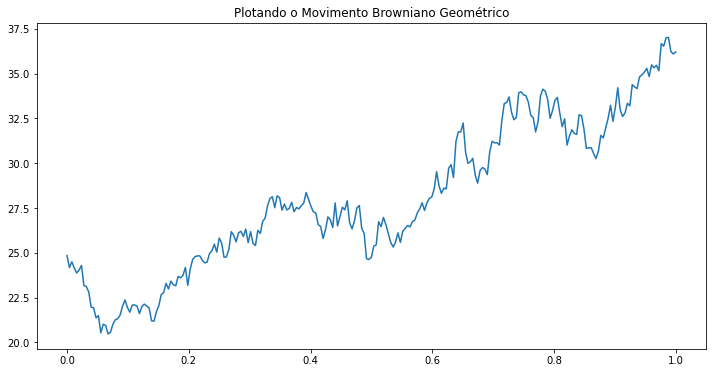

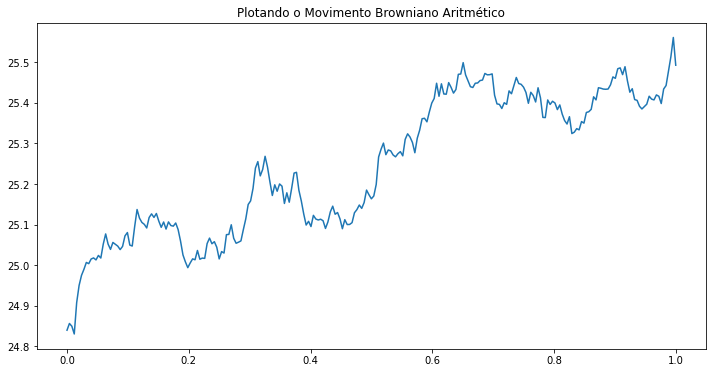

In [9]:
# Argumentos
S0 = df_ativo.iloc[-1,0] # preço na última data disponível
mu = 9.15/100
sigma = asset_ret_pnl['Retorno'].std() * 252**(0.5)
T = 1
n_steps = 252

# Gráfico do GBM (uma trajetória)
plt.figure(figsize=(12,6))
plt.plot(gbm(S0, mu, sigma, T, n_steps))
plt.title('Plotando o Movimento Browniano Geométrico')
plt.show;

# Gráfico do ABM (uma trajetória)
plt.figure(figsize=(12,6))
plt.plot(abm(S0, mu, sigma, T, n_steps))
plt.title('Plotando o Movimento Browniano Aritmético')
plt.show;

In [10]:
# Trajetória simulada
gbm(S0, mu, sigma, T, n_steps).head()

,St
tempo,
0.000000,24.840000
0.003968,26.282800
0.007937,27.097372
0.011905,27.898021
0.015873,28.748558


## Etapa 2:

Expandir a etapa anterior com a metodologia de *Monte Carlo*, onde devem ser geradas $N$ trajetórias diferentes para o preço do ativo subjacente.

Dica: basta adicionar mais um loop no código, englobando o que já foi feito.

In [11]:
def gbm_monte_carlo(S0, mu, sigma, T, n_steps, n_trajs):
    '''
    Função para simular o GBM de um ativo com a metodologia de Monte Carlo.
    
    Args:
        S0: preço inicial do ativo;
        mu: retorno esperado do ativo (taxa livre de risco);
        sigma: volatilidade do ativo;
        T: tempo total;
        n_steps: número de passos;
        n_trajs: número de trajetórias.
        
    Return:
        df: dataframe com os preços simulados para um ativo em várias trajetórias.
    
    '''
    
    # Tamanho do passo
    dt = T/n_steps
    
    df = pd.DataFrame()
    df['tempo'] = np.arange(0, T + dt, dt)
    df.set_index('tempo', inplace=True)

    # Simula as trajetórias
    for traj in range(0, n_trajs):
        St = [S0]
        
        # Calcula o preço do ativo
        for step in range(1, n_steps + 1):
            
            # Processo de Wiener (número aleatório de uma distribuição normal com média 0 e variância 𝑡) 
            W = np.random.normal()

            # 𝑆𝑡 = 𝑆0 * 𝑒**(𝜇 − (𝜎**2/2))*𝑡 + 𝜎*𝑊𝑡
            S = St[step-1] * np.exp((mu - (sigma**2/2)) * dt + sigma * W * np.sqrt(dt))
            St.append(S)

        # Preenche o DF criado com os preços calculados acima
        df['St_'+str(traj)] = St
    
    return df

In [12]:
def abm_monte_carlo(S0, mu, sigma, T, n_steps, n_trajs):
    '''
    Função para simular o ABM de um ativo com a metodologia de Monte Carlo.
    
    Args:
        S0: preço inicial do ativo;
        mu: retorno esperado do ativo (taxa livre de risco);
        sigma: volatilidade do ativo;
        T: tempo total;
        n_steps: número de passos;
        n_trajs: número de trajetórias.
        
    Return:
        df: dataframe com os preços simulados para um ativo em várias trajetórias.
    
    '''
    
    # Tamanho do passo
    dt = T/n_steps
    
    # Criando um DF com o tempo no index
    df = pd.DataFrame()
    df['tempo'] = np.arange(0, T + dt, dt)
    df.set_index('tempo', inplace=True)

    # Simula as trajetórias
    for traj in range(0, n_trajs):
        St = [S0]
        
        # Calcula o preço do ativo
        for step in range(1, n_steps + 1):
            
            # Processo de Wiener (número aleatório de uma distribuição normal com média 0 e variância 𝑡) 
            W = np.random.normal()

            # 𝑑𝑆 = 𝜇𝑑𝑡 + 𝜎𝑑𝑊𝑡
            dS = mu * dt + sigma * W * np.sqrt(dt)

            # Preço = preço anterior + variação em 1 dia
            S = St[step-1] + dS
            St.append(S)

        # Preenche o DF criado com os preços calculados acima
        df['St_'+str(traj)] = St
    
    return df

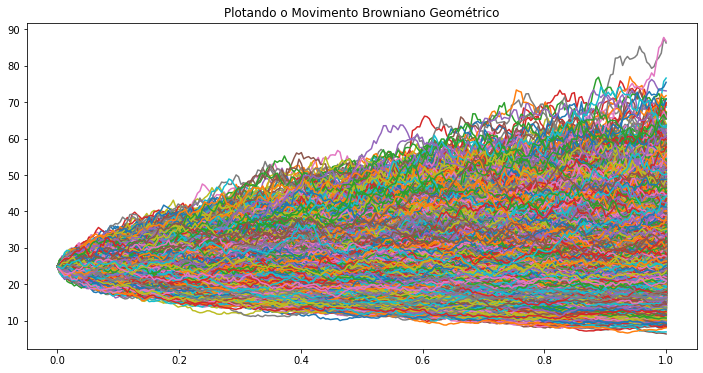

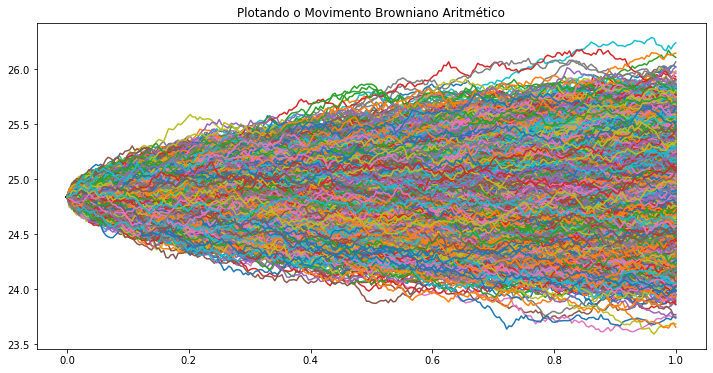

In [13]:
# Argumentos
S0 = df_ativo.iloc[-1,0] # preço na última data disponível
mu = 9.15/100
sigma = asset_ret_pnl['Retorno'].std() * 252**(0.5)
T = 1
n_steps = 252
n_trajs = 10000

# Gráfico do GBM/Monte Carlo
plt.figure(figsize=(12,6))
plt.plot(gbm_monte_carlo(S0, mu, sigma, T, n_steps, n_trajs))
plt.title('Plotando o Movimento Browniano Geométrico')
plt.show;

# Gráfico do ABM/Monte Carlo
plt.figure(figsize=(12,6))
plt.plot(abm_monte_carlo(S0, mu, sigma, T, n_steps, n_trajs))
plt.title('Plotando o Movimento Browniano Aritmético')
plt.show;

In [14]:
# Todas as trajetórias criadas aleatoriamente
gbm_monte_carlo(S0, mu, sigma, T, n_steps, n_trajs).head()

,St_0,St_1,St_2,St_3,St_4,St_5,St_6,St_7,St_8,St_9,...,St_9990,St_9991,St_9992,St_9993,St_9994,St_9995,St_9996,St_9997,St_9998,St_9999
tempo,,,,,,,,,,,,,,,,,,,,,
0.000000,24.840000,24.840000,24.840000,24.840000,24.840000,24.840000,24.840000,24.840000,24.840000,24.840000,...,24.840000,24.840000,24.840000,24.840000,24.840000,24.840000,24.840000,24.840000,24.840000,24.840000
0.003968,24.446573,25.180565,24.417623,25.385799,24.063964,24.679732,25.640741,25.112763,24.773799,24.818472,...,24.703450,24.531812,25.680244,25.699326,25.227257,24.098364,24.984722,25.045888,24.412763,24.484946
0.007937,24.243181,24.830517,25.113296,25.190041,23.863711,23.985671,25.285102,24.486983,25.113800,24.700647,...,24.806090,24.599842,26.494675,25.896413,24.364744,24.525568,25.680204,25.133404,24.760857,23.888627
0.011905,23.888139,24.244266,25.663935,24.973923,24.387165,25.120426,26.250463,23.520043,25.035557,25.430351,...,24.832977,24.394506,27.157849,25.952654,24.148955,25.152179,25.066902,24.576198,24.065041,25.016286
0.015873,24.318628,24.250242,25.388151,25.855281,25.718074,25.047571,26.291461,22.972488,25.190242,25.486035,...,25.918033,24.846834,27.135233,25.636005,24.133088,25.290712,24.696762,24.114259,22.972766,25.727300


## Etapa 3 (Daqui para frente, apenas executar para o *GBM*):

Comparar a trajetória média dentre todas aquelas simuladas com o preço do ativo levado a valor futuro no mesmo período observado/simulado.

Dica:   
Valor presente levado a valor futuro é aproximadamente a trajetória média - pois temos um submartingal   
com taxa de crescimento esperado como sendo o valor de mu.

In [15]:
# Calculando a média dos preços do ativo em todas as trajetórias simuladas
traj_media = gbm_monte_carlo(S0, mu, sigma, T, n_steps, n_trajs).mean(axis=1)
traj_media

tempo
0.000000    24.840000
0.003968    24.844528
0.007937    24.861343
0.011905    24.861616
0.015873    24.875442
              ...    
0.984127    27.142557
0.988095    27.156403
0.992063    27.161470
0.996032    27.165556
1.000000    27.167227
Length: 253, dtype: float64

Preço inicial: 24.84
Preço inicial levado a valor futuro por 1 ano: 27.22


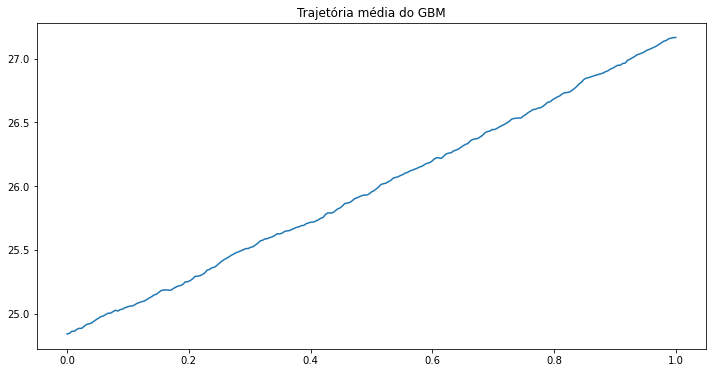

In [16]:
print(f'Preço inicial: {S0:.2f}')

# Preço inicial levado a valor futuro
S0_fut = S0 * np.exp(mu * T)
print(f'Preço inicial levado a valor futuro por 1 ano: {S0_fut:.2f}')

# Gráfico da trajetória média do GBM
plt.figure(figsize=(12,6))
plt.plot(traj_media)
plt.title('Trajetória média do GBM')
plt.show;

## Etapa 4:

Implementar o cálculo do *payoff* de uma opção europeia com *strike* $K$ em cima daquele ativo simulado.

In [17]:
def pay_op_euro(S0, mu, sigma, T, n_steps, n_trajs, K, op_type):
    '''
    Função para calcular o payoff de uma opção europeia.
    
    Args:
        S0: preço inicial do ativo;
        mu: retorno esperado do ativo (taxa livre de risco);
        sigma: volatilidade do ativo;
        T: tempo total;
        n_steps: número de passos;
        n_trajs: número de trajetórias;
        K: valor do strike;
        op_type: tipo da opção (call ou put).
    
    Return:
        price: preço de uma opção europeia.
    '''
    
    # Tamanho do passo
    dt = T/n_steps
    
    pay_sum = 0

    # Simula as trajetórias
    for traj in range(0, n_trajs):
        St = [S0]
        
        # Calcula o preço do ativo
        for step in range(1, n_steps + 1):
            # Processo de Wiener (número aleatório de uma distribuição normal com média 0 e variância 𝑡) 
            W = np.random.normal()
            # 𝑆𝑡 = 𝑆0 * 𝑒**(𝜇 − (𝜎**2/2))*𝑡 + 𝜎*𝑊𝑡
            S = St[step-1] * np.exp((mu - (sigma**2/2)) * dt + sigma * W * np.sqrt(dt))
            St.append(S)
            
        # Calcula o payoff
        if op_type == 'call':
            payoff = max(St[-1] - K, 0)
        elif op_type == 'put':
            payoff = max(K - St[-1], 0)
            
        # Desconta a valor presente
        pay_pres = payoff * np.exp(-mu * T)
        pay_sum += pay_pres
        
    # Média dos payoffs
    price = pay_sum / n_trajs
    
    return price

In [18]:
# Argumentos
S0 = df_ativo.iloc[-1,0] # preço na última data disponível
mu = 9.15/100
sigma = asset_ret_pnl['Retorno'].std() * 252**(0.5)
T = 24/252
n_steps = 252
n_trajs = 10000
K = S0

# Pegando um vencimento de 24 dias úteis para comparar com os valores do site: https://opcoes.net.br/opcoes/bovespa/ITUB4
print('Opções "ITUB4.SA" com vencimento em 24 dias úteis\n')

mc_call = pay_op_euro(S0, mu, sigma, T, n_steps, n_trajs, K, op_type='call')
print(f'Preço de uma call (Monte Carlo): {mc_call:.2f}')

mc_put = pay_op_euro(S0, mu, sigma, T, n_steps, n_trajs, K, op_type='put')
print(f'Preço de uma put (Monte Carlo): {mc_put:.2f}\n')

print(f'Comparar com os preços em: https://opcoes.net.br/opcoes/bovespa/ITUB4')

Opções "ITUB4.SA" com vencimento em 24 dias úteis

Preço de uma call (Monte Carlo): 1.12
Preço de uma put (Monte Carlo): 0.91

Comparar com os preços em: https://opcoes.net.br/opcoes/bovespa/ITUB4


## Etapa 5:

Implementar o *Black-Scholes* (pode reutilizar o código de aulas passadas) e comparar o preço dado pelo *BS* com o preço esperado pela simulação.

Aqui vale ressaltar que o *BS* apenas funciona para opções cujo *strike* está bem próximo do preço, logo, recomenda-se utilizar $K = S_0$.

In [19]:
def calc_BS(S0, K, r, T, sigma, op_type):
    '''
    Função que calcula o preço de uma call/put europeia, de acordo com o modelo B&S.
    
    Args:
        S0: preço do ativo no tempo 0;
        K: strike;
        r: taxa livre de risco com capitalização contínua;
        T: prazo anualizado;
        sigma: volatilidade anual;
        op_type: tipo da opção (call ou put).
        
    Return:
        
        price: preço de uma call/put europeia, de acordo com o modelo B&S.
    '''
    
    # Cálculo do d1
    d1 = (np.log(S0/K) + (r + sigma**2/2)*T) / (sigma*np.sqrt(T))
    # Cálculo do d2
    d2 = d1 - sigma*np.sqrt(T)
    
    if op_type == 'call':
        # Preço se for call (opção de compra)
        price = S0*sts.norm.cdf(d1) - K*np.exp(-r*T)*sts.norm.cdf(d2)
    elif op_type == 'put':
        # preço se for put (opção de venda)
        price = K*np.exp(-r*T)*sts.norm.cdf(-d2) - S0*sts.norm.cdf(-d1)
    else:
        # Não sei o tipo, não calculo
        price = None
    
    return price # Preço/prêmio

In [20]:
# Argumentos
S0 = df_ativo.iloc[-1,0] # preço na última data disponível
K = S0 # ATM
mu = 9.15/100
r = np.log(1 + mu)
T = 24/252
sigma = asset_ret_pnl['Retorno'].std() * 252**(0.5)

# Pegando um vencimento de 24 dias úteis para comparar com os valores do site: https://opcoes.net.br/opcoes/bovespa/ITUB4
print('Opções "ITUB4.SA" com vencimento em 24 dias úteis\n')

bs_call = calc_BS(S0, K, r, T, sigma, op_type='call')
print(f'Preço de uma call (Black & Scholes): {bs_call:.2f}')

bs_put = calc_BS(S0, K, r, T, sigma, op_type='put')
print(f'Preço de uma put (Black & Scholes): {bs_put:.2f}\n')

print(f'Comparar com os preços em: https://opcoes.net.br/opcoes/bovespa/ITUB4')

Opções "ITUB4.SA" com vencimento em 24 dias úteis

Preço de uma call (Black & Scholes): 1.13
Preço de uma put (Black & Scholes): 0.93

Comparar com os preços em: https://opcoes.net.br/opcoes/bovespa/ITUB4


## Etapa 6:

Implementar o cálculo do *VaR* e do *ES* (*CVaR*) para as simulações executadas para o ativo subjacente.

In [21]:
def var_es(df):
    '''
    Função para calcular o VaR e ES de um ativo.
    
    Arg:
        df: dataframe com os preços de um ativo.
        
    Return:
        var, es: valores do VaR e ES de um ativo.
    '''
    
    df_metrics = calc_ret_pnl(df, hp=1)

    amostra_PnL = df_metrics.PnL
    
    alpha = 0.05
    var = amostra_PnL.quantile(alpha)
    es = amostra_PnL[amostra_PnL <= var].mean()
    
    return var, es

In [22]:
T = 1 # redefinindo o valor de T

# Argumento
df = pd.DataFrame(gbm_monte_carlo(S0, mu, sigma, T, n_steps, n_trajs).iloc[-1,:]) # 10 mil preços simulados no vencimento

# Carregando os valores do VaR e ES de "ITUB4.SA" simulado
var = var_es(df)[0]
es = var_es(df)[1]

print('ITUB4.SA: preços simulados no vencimento\n')
print("VaR 95% = R$ " + "{:.2f}".format(-var))
print("ES 95% = R$ " + "{:.2f}".format(-es))

ITUB4.SA: preços simulados no vencimento

VaR 95% = R$ 21.93
ES 95% = R$ 29.40


In [23]:
def var_es_series(df):
    '''
    Função para calcular uma série temporal de VaR e ES de um ativo.
    
    Obs.: no caso abaixo, não seria uma série "temporal", pois vamos pegar 10 mil preços simulados em um mesmo dia (vencimento).
    
    Arg:
        df: dataframe com os preços de um ativo.
        
    Return:
        df: dataframe com os valores do VaR e ES de um ativo.
    '''
    
    pnl = calc_ret_pnl(df, hp).PnL
    
    list_simul = []
    list_var = []
    list_es = [] 

    # Iterando de trás para frente, pois a "amostra_PnL" pega primeiro os 1000 dias mais recentes. 
    for i in range(len(pnl), 0, -1): 
        amostra_PnL = pnl.iloc[len(pnl)-1000-i:len(pnl)-i]
        var = amostra_PnL.quantile(0.05)
        list_var.append(var)
        es = amostra_PnL[amostra_PnL <= var].mean()
        list_es.append(es)
        list_simul.append(pnl.index[len(pnl)-i])

    df = pd.DataFrame()
    df['Simulações'] = list_simul
    df.set_index('Simulações', inplace=True)
    df['PnL'] = pnl
    df['VaR 95%'] = list_var
    df['ES 95%'] = list_es
    
    return df

In [24]:
# Argumento
df = pd.DataFrame(gbm_monte_carlo(S0, mu, sigma, T, n_steps, n_trajs).iloc[-1,:]) # 10 mil preços simulados no vencimento

# Carregando os valores do VaR e ES de "ITUB4.SA" simulado
var_es_series(df)

,PnL,VaR 95%,ES 95%
Simulações,,,
St_0,NaN,NaN,NaN
St_1,-13.557764,NaN,NaN
St_2,13.944126,NaN,NaN
St_3,-18.757037,NaN,NaN
St_4,11.200713,NaN,NaN
...,...,...,...
St_9995,-8.958573,-21.831894,-26.796437
St_9996,0.116932,-21.831894,-26.796437
St_9997,8.000444,-21.831894,-26.796437


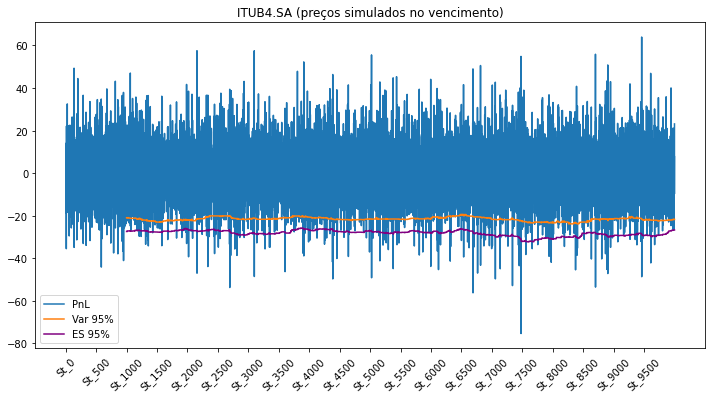

In [25]:
# Gráfico do VaR e ES sobre o PnL de "ITUB4.SA" simulado
plt.figure(figsize=(12,6))
plt.plot(var_es_series(df)['PnL'], label='PnL')
plt.plot(var_es_series(df)['VaR 95%'], label='Var 95%')
plt.plot(var_es_series(df)['ES 95%'], label='ES 95%', color='purple')
plt.legend()
plt.title('ITUB4.SA (preços simulados no vencimento)')
plt.xticks(np.arange(0, len(var_es_series(df)), 500), rotation=45)
plt.show();